In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

!pip install optuna
import optuna

import dataProcess

from datetime import datetime

import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 11.5 MB/s eta 0:00:00


In [2]:
# data preprocessing

#start = datetime(2024, 1, 3).date()
#end = datetime(2024, 4, 11).date()
#hourly ='weatherstats_toronto_hourly.csv'
#daily ='weatherstats_toronto_daily.csv'
hourly = 'weatherstats_toronto_hourly_10_yr.csv'
daily = 'weatherstats_toronto_daily_10_yr.csv'
start = datetime(2014, 4, 15).date()
end = datetime(2024, 4, 11).date()
data = dataProcess.generateDataNoLoader(hourly, daily, start, end)
train_data = data['train']
val_data = data['validation']
test_data = data['test']

In [3]:
#accuracy func
def accuracy(model, data):
    batch_size = 100
    totalDiff = 0.0
    count = 0
    loader = DataLoader(data, batch_size=batch_size)
    for data, target in loader:
        count = count + len(target)
        z = model(data)
        totalDiff += torch.sum(torch.abs(target - z))
    return(totalDiff / count)


In [4]:
#define model
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        #recurrent layer - stacked once for extra modelling
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=2)
        #fully connected layer - 3 layers
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.fc3 = nn.Linear(int(hidden_size/2), output_size)
        self.relu = nn.ReLU()

    def forward(self, X):
        # Initialize hidden state
        # Forward pass through RNN
        X = X.to(torch.float32)
        h_0 = torch.zeros(2, X.size(0), self.hidden_size).to(X.device)
        #print(X.shape)
        output, h_n = self.rnn(X, h_0)
        #print(output.shape)
        #get output of the RNN at the last timestep
        #print(output.shape)
        rnn_output_last = output[:,-1,:]
        # Apply fully connected layer to the output of the last timestep
        out = self.fc1(rnn_output_last)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = torch.squeeze(out)

        return out

In [5]:
def train_model(model, trainData, valData, lr=.002, batchSize=10, epochs=100, v=True):
  train_loader = DataLoader(train_data, batch_size=batchSize, shuffle=False)
  val_loader = DataLoader(val_data, batch_size=batchSize, shuffle=False)
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()
  model.train()
  for epoch in range(epochs):
    total_loss = 0

    for inputs, targets in train_loader:

      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)

      #print(outputs.shape)

      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    if v:
      print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {total_loss / len(train_loader):.4f}')

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()
    if v:
      print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {total_val_loss / len(val_loader):.4f}')

In [6]:
def objective(trial):
    lr = trial.suggest_float('lr', .001, .05)
    batchSize = trial.suggest_int('batchSize', 5, 100)
    epochs = trial.suggest_int('epochs', 5, 100)
    hidden_size = trial.suggest_int('hidden_size', 10, 312)
    model = MyRNN(hidden_size=hidden_size, input_size = 13, output_size = 1)
    print(f'lr: {lr}, batchSize: {batchSize}, epochs: {epochs}, hidden_size: {hidden_size}')
    train_model(model, train_data, val_data, lr=lr, batchSize=batchSize, epochs=epochs, v=False)
    return accuracy(model, data['validation'])

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-04-19 08:30:52,227] A new study created in memory with name: no-name-4bb6063b-0e7d-4421-9b92-aace92c2d815


lr: 0.022113413618888574, batchSize: 50, epochs: 50, hidden_size: 45


[I 2024-04-19 08:31:27,890] Trial 0 finished with value: 9.263215065002441 and parameters: {'lr': 0.022113413618888574, 'batchSize': 50, 'epochs': 50, 'hidden_size': 45}. Best is trial 0 with value: 9.263215065002441.


lr: 0.013602050786288681, batchSize: 99, epochs: 50, hidden_size: 254


[I 2024-04-19 08:33:06,299] Trial 1 finished with value: 9.263501167297363 and parameters: {'lr': 0.013602050786288681, 'batchSize': 99, 'epochs': 50, 'hidden_size': 254}. Best is trial 0 with value: 9.263215065002441.


lr: 0.01575152932095421, batchSize: 64, epochs: 16, hidden_size: 55


[I 2024-04-19 08:33:14,445] Trial 2 finished with value: 9.2637939453125 and parameters: {'lr': 0.01575152932095421, 'batchSize': 64, 'epochs': 16, 'hidden_size': 55}. Best is trial 0 with value: 9.263215065002441.


lr: 0.01547016260010712, batchSize: 29, epochs: 75, hidden_size: 41


[I 2024-04-19 08:34:08,490] Trial 3 finished with value: 9.267550468444824 and parameters: {'lr': 0.01547016260010712, 'batchSize': 29, 'epochs': 75, 'hidden_size': 41}. Best is trial 0 with value: 9.263215065002441.


lr: 0.002607556200042739, batchSize: 70, epochs: 26, hidden_size: 302


[I 2024-04-19 08:39:25,797] Trial 4 finished with value: 9.263850212097168 and parameters: {'lr': 0.002607556200042739, 'batchSize': 70, 'epochs': 26, 'hidden_size': 302}. Best is trial 0 with value: 9.263215065002441.


lr: 0.00891430898716673, batchSize: 18, epochs: 69, hidden_size: 197


[I 2024-04-19 08:42:27,432] Trial 5 finished with value: 9.265021324157715 and parameters: {'lr': 0.00891430898716673, 'batchSize': 18, 'epochs': 69, 'hidden_size': 197}. Best is trial 0 with value: 9.263215065002441.


lr: 0.032842290500392765, batchSize: 35, epochs: 12, hidden_size: 118


[I 2024-04-19 08:42:42,714] Trial 6 finished with value: 9.3302640914917 and parameters: {'lr': 0.032842290500392765, 'batchSize': 35, 'epochs': 12, 'hidden_size': 118}. Best is trial 0 with value: 9.263215065002441.


lr: 0.014180572835145868, batchSize: 100, epochs: 86, hidden_size: 80


[I 2024-04-19 08:43:25,079] Trial 7 finished with value: 9.26347827911377 and parameters: {'lr': 0.014180572835145868, 'batchSize': 100, 'epochs': 86, 'hidden_size': 80}. Best is trial 0 with value: 9.263215065002441.


lr: 0.038879569317355624, batchSize: 26, epochs: 33, hidden_size: 131


[I 2024-04-19 08:44:04,682] Trial 8 finished with value: 9.264240264892578 and parameters: {'lr': 0.038879569317355624, 'batchSize': 26, 'epochs': 33, 'hidden_size': 131}. Best is trial 0 with value: 9.263215065002441.


lr: 0.035889176196171796, batchSize: 51, epochs: 11, hidden_size: 121


[I 2024-04-19 08:44:14,074] Trial 9 finished with value: 9.336017608642578 and parameters: {'lr': 0.035889176196171796, 'batchSize': 51, 'epochs': 11, 'hidden_size': 121}. Best is trial 0 with value: 9.263215065002441.


lr: 0.047772397335956694, batchSize: 6, epochs: 52, hidden_size: 12


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[I 2024-04-19 08:46:12,948] Trial 10 finished with value: 9.263213157653809 and parameters: {'lr': 0.047772397335956694, 'batchSize': 6, 'epochs': 52, 'hidden_size': 12}. Best is trial 10 with value: 9.263213157653809.


lr: 0.04849921207173211, batchSize: 5, epochs: 49, hidden_size: 10


[I 2024-04-19 08:48:27,684] Trial 11 finished with value: 9.263504981994629 and parameters: {'lr': 0.04849921207173211, 'batchSize': 5, 'epochs': 49, 'hidden_size': 10}. Best is trial 10 with value: 9.263213157653809.


lr: 0.025201634574392322, batchSize: 47, epochs: 61, hidden_size: 10


[I 2024-04-19 08:48:47,691] Trial 12 finished with value: 9.266083717346191 and parameters: {'lr': 0.025201634574392322, 'batchSize': 47, 'epochs': 61, 'hidden_size': 10}. Best is trial 10 with value: 9.263213157653809.


lr: 0.026387565544004333, batchSize: 83, epochs: 100, hidden_size: 188


[I 2024-04-19 08:50:44,646] Trial 13 finished with value: 9.263213157653809 and parameters: {'lr': 0.026387565544004333, 'batchSize': 83, 'epochs': 100, 'hidden_size': 188}. Best is trial 10 with value: 9.263213157653809.


lr: 0.04919316064222471, batchSize: 83, epochs: 100, hidden_size: 192


[I 2024-04-19 08:52:57,003] Trial 14 finished with value: 9.263444900512695 and parameters: {'lr': 0.04919316064222471, 'batchSize': 83, 'epochs': 100, 'hidden_size': 192}. Best is trial 10 with value: 9.263213157653809.


lr: 0.04120815370458664, batchSize: 82, epochs: 99, hidden_size: 235


[I 2024-04-19 08:59:44,062] Trial 15 finished with value: 9.263893127441406 and parameters: {'lr': 0.04120815370458664, 'batchSize': 82, 'epochs': 99, 'hidden_size': 235}. Best is trial 10 with value: 9.263213157653809.


lr: 0.028755514582734582, batchSize: 5, epochs: 35, hidden_size: 165


[I 2024-04-19 09:02:38,184] Trial 16 finished with value: 9.263212203979492 and parameters: {'lr': 0.028755514582734582, 'batchSize': 5, 'epochs': 35, 'hidden_size': 165}. Best is trial 16 with value: 9.263212203979492.


lr: 0.04334211544903248, batchSize: 6, epochs: 37, hidden_size: 150


[I 2024-04-19 09:05:05,240] Trial 17 finished with value: 9.263213157653809 and parameters: {'lr': 0.04334211544903248, 'batchSize': 6, 'epochs': 37, 'hidden_size': 150}. Best is trial 16 with value: 9.263212203979492.


lr: 0.03049636338093286, batchSize: 18, epochs: 38, hidden_size: 87


[I 2024-04-19 09:05:50,638] Trial 18 finished with value: 9.265628814697266 and parameters: {'lr': 0.03049636338093286, 'batchSize': 18, 'epochs': 38, 'hidden_size': 87}. Best is trial 16 with value: 9.263212203979492.


lr: 0.02070693104931251, batchSize: 16, epochs: 60, hidden_size: 236


[I 2024-04-19 09:09:03,108] Trial 19 finished with value: 9.265012741088867 and parameters: {'lr': 0.02070693104931251, 'batchSize': 16, 'epochs': 60, 'hidden_size': 236}. Best is trial 16 with value: 9.263212203979492.


lr: 0.029762866195650453, batchSize: 41, epochs: 24, hidden_size: 165


[I 2024-04-19 09:09:31,752] Trial 20 finished with value: 9.283527374267578 and parameters: {'lr': 0.029762866195650453, 'batchSize': 41, 'epochs': 24, 'hidden_size': 165}. Best is trial 16 with value: 9.263212203979492.


lr: 0.025730980981478982, batchSize: 63, epochs: 83, hidden_size: 188


[I 2024-04-19 09:11:30,320] Trial 21 finished with value: 9.263426780700684 and parameters: {'lr': 0.025730980981478982, 'batchSize': 63, 'epochs': 83, 'hidden_size': 188}. Best is trial 16 with value: 9.263212203979492.


lr: 0.04529662171345804, batchSize: 11, epochs: 42, hidden_size: 168


[I 2024-04-19 09:13:18,053] Trial 22 finished with value: 9.264307975769043 and parameters: {'lr': 0.04529662171345804, 'batchSize': 11, 'epochs': 42, 'hidden_size': 168}. Best is trial 16 with value: 9.263212203979492.


lr: 0.03625758391955413, batchSize: 26, epochs: 61, hidden_size: 224


[I 2024-04-19 09:15:29,086] Trial 23 finished with value: 9.264358520507812 and parameters: {'lr': 0.03625758391955413, 'batchSize': 26, 'epochs': 61, 'hidden_size': 224}. Best is trial 16 with value: 9.263212203979492.


lr: 0.027723040950757134, batchSize: 84, epochs: 29, hidden_size: 286


[I 2024-04-19 09:16:33,186] Trial 24 finished with value: 9.266412734985352 and parameters: {'lr': 0.027723040950757134, 'batchSize': 84, 'epochs': 29, 'hidden_size': 286}. Best is trial 16 with value: 9.263212203979492.


lr: 0.020803115561130785, batchSize: 74, epochs: 71, hidden_size: 205


[I 2024-04-19 09:18:26,655] Trial 25 finished with value: 9.264663696289062 and parameters: {'lr': 0.020803115561130785, 'batchSize': 74, 'epochs': 71, 'hidden_size': 205}. Best is trial 16 with value: 9.263212203979492.


lr: 0.03394538632203899, batchSize: 59, epochs: 44, hidden_size: 96


[I 2024-04-19 09:18:52,950] Trial 26 finished with value: 9.263215065002441 and parameters: {'lr': 0.03394538632203899, 'batchSize': 59, 'epochs': 44, 'hidden_size': 96}. Best is trial 16 with value: 9.263212203979492.


lr: 0.03853901215506954, batchSize: 91, epochs: 90, hidden_size: 138


[I 2024-04-19 09:20:49,085] Trial 27 finished with value: 9.263214111328125 and parameters: {'lr': 0.03853901215506954, 'batchSize': 91, 'epochs': 90, 'hidden_size': 138}. Best is trial 16 with value: 9.263212203979492.


lr: 0.006097482167356463, batchSize: 38, epochs: 20, hidden_size: 264


[I 2024-04-19 09:23:06,179] Trial 28 finished with value: 9.299357414245605 and parameters: {'lr': 0.006097482167356463, 'batchSize': 38, 'epochs': 20, 'hidden_size': 264}. Best is trial 16 with value: 9.263212203979492.


lr: 0.024156365828907757, batchSize: 12, epochs: 53, hidden_size: 174


[I 2024-04-19 09:25:28,053] Trial 29 finished with value: 9.265778541564941 and parameters: {'lr': 0.024156365828907757, 'batchSize': 12, 'epochs': 53, 'hidden_size': 174}. Best is trial 16 with value: 9.263212203979492.


lr: 0.021594501758183258, batchSize: 23, epochs: 53, hidden_size: 106


[I 2024-04-19 09:26:34,896] Trial 30 finished with value: 9.265196800231934 and parameters: {'lr': 0.021594501758183258, 'batchSize': 23, 'epochs': 53, 'hidden_size': 106}. Best is trial 16 with value: 9.263212203979492.


lr: 0.04240292532171738, batchSize: 5, epochs: 35, hidden_size: 148


[I 2024-04-19 09:29:19,898] Trial 31 finished with value: 9.428756713867188 and parameters: {'lr': 0.04240292532171738, 'batchSize': 5, 'epochs': 35, 'hidden_size': 148}. Best is trial 16 with value: 9.263212203979492.


lr: 0.045214846296987965, batchSize: 11, epochs: 45, hidden_size: 153


[I 2024-04-19 09:31:12,135] Trial 32 finished with value: 9.264310836791992 and parameters: {'lr': 0.045214846296987965, 'batchSize': 11, 'epochs': 45, 'hidden_size': 153}. Best is trial 16 with value: 9.263212203979492.


lr: 0.046512775007611966, batchSize: 6, epochs: 39, hidden_size: 57


[I 2024-04-19 09:32:58,472] Trial 33 finished with value: 9.263212203979492 and parameters: {'lr': 0.046512775007611966, 'batchSize': 6, 'epochs': 39, 'hidden_size': 57}. Best is trial 16 with value: 9.263212203979492.


lr: 0.01797725151118259, batchSize: 18, epochs: 55, hidden_size: 44


[I 2024-04-19 09:33:49,738] Trial 34 finished with value: 9.265419960021973 and parameters: {'lr': 0.01797725151118259, 'batchSize': 18, 'epochs': 55, 'hidden_size': 44}. Best is trial 16 with value: 9.263212203979492.


lr: 0.04715485859984415, batchSize: 31, epochs: 47, hidden_size: 66


[I 2024-04-19 09:34:25,608] Trial 35 finished with value: 9.265061378479004 and parameters: {'lr': 0.04715485859984415, 'batchSize': 31, 'epochs': 47, 'hidden_size': 66}. Best is trial 16 with value: 9.263212203979492.


lr: 0.009702534953323946, batchSize: 93, epochs: 6, hidden_size: 29


[I 2024-04-19 09:34:27,033] Trial 36 finished with value: 9.26323127746582 and parameters: {'lr': 0.009702534953323946, 'batchSize': 93, 'epochs': 6, 'hidden_size': 29}. Best is trial 16 with value: 9.263212203979492.


lr: 0.040226727855027004, batchSize: 45, epochs: 28, hidden_size: 61


[I 2024-04-19 09:34:41,137] Trial 37 finished with value: 9.270304679870605 and parameters: {'lr': 0.040226727855027004, 'batchSize': 45, 'epochs': 28, 'hidden_size': 61}. Best is trial 16 with value: 9.263212203979492.


lr: 0.03154522264941908, batchSize: 55, epochs: 67, hidden_size: 216


[I 2024-04-19 09:36:25,737] Trial 38 finished with value: 9.264822006225586 and parameters: {'lr': 0.03154522264941908, 'batchSize': 55, 'epochs': 67, 'hidden_size': 216}. Best is trial 16 with value: 9.263212203979492.


lr: 0.017482370045717115, batchSize: 10, epochs: 39, hidden_size: 31


[I 2024-04-19 09:37:27,394] Trial 39 finished with value: 9.26809310913086 and parameters: {'lr': 0.017482370045717115, 'batchSize': 10, 'epochs': 39, 'hidden_size': 31}. Best is trial 16 with value: 9.263212203979492.


lr: 0.027732839202725134, batchSize: 73, epochs: 76, hidden_size: 32


[I 2024-04-19 09:37:55,415] Trial 40 finished with value: 9.263212203979492 and parameters: {'lr': 0.027732839202725134, 'batchSize': 73, 'epochs': 76, 'hidden_size': 32}. Best is trial 16 with value: 9.263212203979492.


lr: 0.02833221403183922, batchSize: 72, epochs: 80, hidden_size: 28


[I 2024-04-19 09:38:26,389] Trial 41 finished with value: 9.263339042663574 and parameters: {'lr': 0.02833221403183922, 'batchSize': 72, 'epochs': 80, 'hidden_size': 28}. Best is trial 16 with value: 9.263212203979492.


lr: 0.03471790695618877, batchSize: 79, epochs: 94, hidden_size: 70


[I 2024-04-19 09:39:13,269] Trial 42 finished with value: 9.263240814208984 and parameters: {'lr': 0.03471790695618877, 'batchSize': 79, 'epochs': 94, 'hidden_size': 70}. Best is trial 16 with value: 9.263212203979492.


lr: 0.036940849464627064, batchSize: 90, epochs: 77, hidden_size: 51


[I 2024-04-19 09:39:39,663] Trial 43 finished with value: 9.263347625732422 and parameters: {'lr': 0.036940849464627064, 'batchSize': 90, 'epochs': 77, 'hidden_size': 51}. Best is trial 16 with value: 9.263212203979492.


lr: 0.02351670885060203, batchSize: 64, epochs: 57, hidden_size: 21


[I 2024-04-19 09:40:00,309] Trial 44 finished with value: 9.263213157653809 and parameters: {'lr': 0.02351670885060203, 'batchSize': 64, 'epochs': 57, 'hidden_size': 21}. Best is trial 16 with value: 9.263212203979492.


lr: 0.0268557871918918, batchSize: 77, epochs: 67, hidden_size: 40


[I 2024-04-19 09:40:25,022] Trial 45 finished with value: 9.263545036315918 and parameters: {'lr': 0.0268557871918918, 'batchSize': 77, 'epochs': 67, 'hidden_size': 40}. Best is trial 16 with value: 9.263212203979492.


lr: 0.04962457516622681, batchSize: 95, epochs: 74, hidden_size: 181


[I 2024-04-19 09:41:49,930] Trial 46 finished with value: 9.264162063598633 and parameters: {'lr': 0.04962457516622681, 'batchSize': 95, 'epochs': 74, 'hidden_size': 181}. Best is trial 16 with value: 9.263212203979492.


lr: 0.04680489056985309, batchSize: 22, epochs: 87, hidden_size: 111


[I 2024-04-19 09:43:36,537] Trial 47 finished with value: 9.265055656433105 and parameters: {'lr': 0.04680489056985309, 'batchSize': 22, 'epochs': 87, 'hidden_size': 111}. Best is trial 16 with value: 9.263212203979492.


lr: 0.03269573076436322, batchSize: 87, epochs: 32, hidden_size: 10


[I 2024-04-19 09:43:43,335] Trial 48 finished with value: 9.263152122497559 and parameters: {'lr': 0.03269573076436322, 'batchSize': 87, 'epochs': 32, 'hidden_size': 10}. Best is trial 48 with value: 9.263152122497559.


lr: 0.032217644553960485, batchSize: 68, epochs: 30, hidden_size: 14


[I 2024-04-19 09:43:51,814] Trial 49 finished with value: 9.263215065002441 and parameters: {'lr': 0.032217644553960485, 'batchSize': 68, 'epochs': 30, 'hidden_size': 14}. Best is trial 48 with value: 9.263152122497559.


In [7]:

print(study.best_params)

model = MyRNN(hidden_size=study.best_params['hidden_size'], input_size = 13, output_size = 1)
train_model(model, train_data, val_data, lr=study.best_params['lr'], batchSize=study.best_params['batchSize'], epochs=study.best_params['epochs'])
#{'lr': 0.03269573076436322, 'batchSize': 87, 'epochs': 32, 'hidden_size': 10}
print(accuracy(model, data['test']))
torch.save(model, 'model.pt')#save model data



{'lr': 0.03269573076436322, 'batchSize': 87, 'epochs': 32, 'hidden_size': 10}
Epoch [1/32], Training Loss: 138.1064
Epoch [1/32], Validation Loss: 112.1168
Epoch [2/32], Training Loss: 120.2243
Epoch [2/32], Validation Loss: 108.8353
Epoch [3/32], Training Loss: 117.2203
Epoch [3/32], Validation Loss: 108.8371
Epoch [4/32], Training Loss: 117.4130
Epoch [4/32], Validation Loss: 108.8482
Epoch [5/32], Training Loss: 117.4081
Epoch [5/32], Validation Loss: 108.8389
Epoch [6/32], Training Loss: 117.3574
Epoch [6/32], Validation Loss: 108.8408
Epoch [7/32], Training Loss: 117.3542
Epoch [7/32], Validation Loss: 108.8396
Epoch [8/32], Training Loss: 117.3387
Epoch [8/32], Validation Loss: 108.8393
Epoch [9/32], Training Loss: 117.3288
Epoch [9/32], Validation Loss: 108.8389
Epoch [10/32], Training Loss: 117.3193
Epoch [10/32], Validation Loss: 108.8386
Epoch [11/32], Training Loss: 117.3108
Epoch [11/32], Validation Loss: 108.8383
Epoch [12/32], Training Loss: 117.3029
Epoch [12/32], Valida

In [8]:
def collect_data(model, data_loader, device):
  model.eval()
  total_mae = 0
  count = 0
  predictions = []
  actuals = []


  with torch.no_grad():
    for inputs, targets in data_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs, targets = inputs.float(), targets.float()
      outputs = model(inputs)
      count += 1

      predictions.extend(outputs.view(-1).detach().cpu().numpy())
      actuals.extend(targets.view(-1).detach().cpu().numpy())


  return predictions, actuals

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
batchSize= 7
test_loader = DataLoader(test_data, batch_size=batchSize, shuffle=False)
predictions, actuals = collect_data(model, test_loader, device)

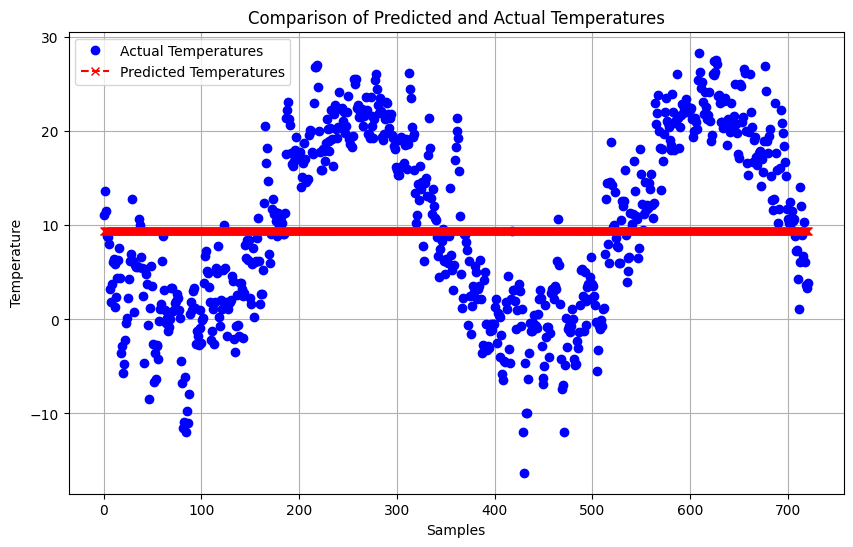

In [9]:
def plot_predictions_vs_actuals(predictions, actuals):
  plt.figure(figsize=(10, 6))
  plt.plot(actuals, label='Actual Temperatures', color='blue', marker='o', linestyle='')
  plt.plot(predictions, label='Predicted Temperatures', color='red', linestyle='--', marker='x')
  plt.title('Comparison of Predicted and Actual Temperatures')
  plt.xlabel('Samples')
  plt.ylabel('Temperature')
  plt.legend()
  plt.grid(True)
  plt.show()

plot_predictions_vs_actuals(predictions, actuals)